<a href="https://colab.research.google.com/github/flavji/sysc4415/blob/main/sysc4415_w23_a1_flavji543.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
GENERAL NOTE: Please print out numbers (i.e., accuracies, plots, etc.) so they are displayed to me when I run your cells. Use python's print() function.
"""

# import everything you might need

import torch
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_absolute_error
import pandas as pd
from xgboost import XGBClassifier
import random
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

**QUESTION 1**

In [ ]:
"""
Q1: Calculate the gradient of the f(x, y, z) = 7x2z – 2xy3 + 5z at (-1, -2, 3). What does this vector represent?

∇f(−1,−2,3) = −26i + 24j + 12k
This vector represents the rate of change of f(x,y,z) at (-1,-2,3)
"""

'\nQ1: Calculate the gradient of the f(x, y, z) = 7x2z – 2xy3 + 5z at (-1, -2, 3). What does this vector represent?\n\n∇f(−1,−2,3)=−26i+24j+12k\nThis vector represents the rate of change of f(x,y,z) at (-1,-2,3)\n'

**QUESTION 2**

In [ ]:
# Let me download the files for you

!wget https://github.com/jrgreen7/SYSC4906/releases/download/Ass1/train.csv
!wget https://github.com/jrgreen7/SYSC4906/releases/download/Ass1/val.csv
!wget https://github.com/jrgreen7/SYSC4906/releases/download/Ass1/test.csv

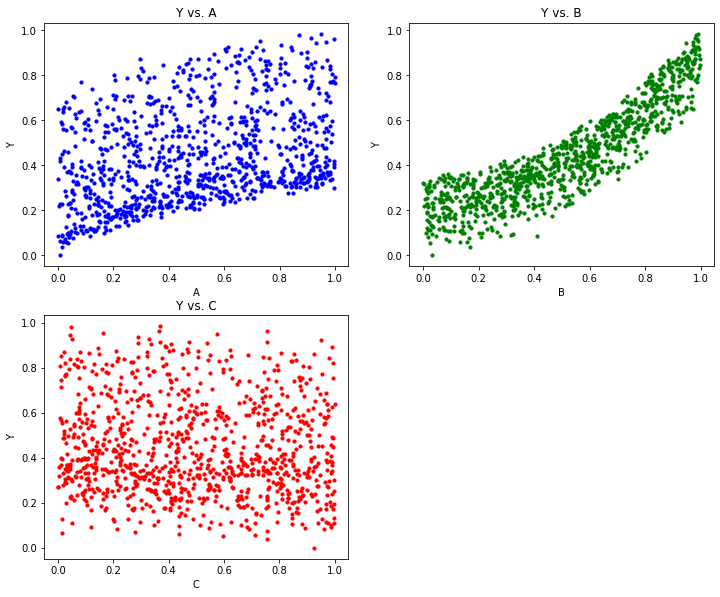

In [ ]:
"""
Q2a: Use pandas to load train.csv, val.csv, and test.csv into three separate dataframes.
Then, create three scatter plots of the train set with features A, B, and C on the x-axes and Y on the y-axes.
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# downloading and extracting datasets from Github and storing to Pandas Dataframe
urlTrain = 'https://github.com/jrgreen7/SYSC4906/releases/download/Ass1/train.csv'
urlVal = 'https://github.com/jrgreen7/SYSC4906/releases/download/Ass1/val.csv'
urlTest = 'https://github.com/jrgreen7/SYSC4906/releases/download/Ass1/test.csv'
dfTrain = pd.read_csv(urlTrain)
dfVal = pd.read_csv(urlVal)
dfTest = pd.read_csv(urlTest)

# unpacking columns into individual variables
trainA = dfTrain['A']
trainB = dfTrain['B']
trainC = dfTrain['C']
trainY= dfTrain['Y']
trainLabel = dfTrain['Label']

# plotting A, B, and C against Y
plt.figure(figsize= (12,26))

plt.subplot(5, 2, 1); plt.scatter(trainA, trainY, s=10, c='b'); plt.xlabel("A"); plt.ylabel("Y"); plt.title("Y vs. A")
plt.subplot(5, 2, 2); plt.scatter(trainB, trainY, s=10, c='g'); plt.xlabel("B"); plt.ylabel("Y"); plt.title("Y vs. B")
plt.subplot(5, 2, 3); plt.scatter(trainC, trainY, s=10, c='r'); plt.xlabel("C"); plt.ylabel("Y"); plt.title("Y vs. C")

plt.show()

In [ ]:
"""
Q2b: If you were using A, B, and C to predict Y (i.e., using linear regression), how well do you think these features would perform?
Do you think nonlinear functions would fit the data better? Why or why not?

A and B would work well to predict Y as the Y vs A plot grows in density along a line but Y vs B would work better due to the better density, even though its slightly curved.
B would work better with a nonlinear function and C will not really work well as the data is scattered all over with no strong visible density.
"""

In [ ]:
"""
Q2c: The data is already normalized, how can you tell?

The data is normalized as the values for A, B, C, and Y stay within the range of 0 and 1.
"""
dfTrain.describe()

,A,B,C,Y,Label,sqrtA,sqrt(A),sqrt(B),sqrt(C),A2,B2,C2
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1.000000e+03
mean,0.494402,0.508317,0.487465,0.444108,3.764000,0.662828,0.662828,0.674323,0.655804,3.271466e-01,0.339024,3.231400e-01
std,0.287743,0.284111,0.292580,0.210157,2.183362,0.234768,0.234768,0.231643,0.239674,2.979967e-01,0.294233,3.010605e-01
min,0.000100,0.000000,0.000108,0.000000,0.000000,0.009981,0.009981,0.000000,0.010408,9.924199e-09,0.000000,1.173392e-08
25%,0.250918,0.275228,0.230890,0.287641,2.000000,0.500917,0.500917,0.524622,0.480510,6.296033e-02,0.075751,5.331011e-02
50%,0.485486,0.515976,0.468818,0.395947,3.000000,0.696768,0.696768,0.718315,0.684703,2.356968e-01,0.266231,2.197906e-01
75%,0.729613,0.747734,0.750513,0.589799,5.000000,0.854174,0.854174,0.864716,0.866322,5.323353e-01,0.559107,5.632708e-01
max,0.998230,0.997099,0.999805,0.984138,9.000000,0.999114,0.999114,0.998549,0.999903,9.964621e-01,0.994207,9.996106e-01


In [ ]:
"""
Q2d: For each of the three input features, compute its square-root to create 3 additional features. Repeat for squaring the feature values to create another 3 features.
You now have 9 total input features: A, B, C, sqrt(A), sqrt(B), sqrt(C), A2, B2, C2. 
Do this for all three data splits (train, val, and test). You can think of these as polynomial kernels used in SVMs.
"""
import numpy as np

#creating additional vectors for training dataset with variables declared in Q2a
dfTrain['sqrt(A)'] = np.sqrt(trainA)
dfTrain['sqrt(B)'] = np.sqrt(trainB)
dfTrain['sqrt(C)'] = np.sqrt(trainC)
dfTrain['A2'] = np.square(trainA)
dfTrain['B2'] = np.square(trainB)
dfTrain['C2'] = np.square(trainC)

print("Train dataset sample:\n", dfTrain.head())

#creating additional vectors for validation dataset
dfVal['sqrt(A)'] = np.sqrt(dfVal['A'])
dfVal['sqrt(B)'] = np.sqrt(dfVal['B'])
dfVal['sqrt(C)'] = np.sqrt(dfVal['C'])
dfVal['A2'] = np.square(dfVal['A'])
dfVal['B2'] = np.square(dfVal['B'])
dfVal['C2'] = np.square(dfVal['C'])

print("\nValue dataset sample:\n", dfVal.head())

#creating additional vectors for testing dataset
dfTest['sqrt(A)'] = np.sqrt(dfTest['A'])
dfTest['sqrt(B)'] = np.sqrt(dfTest['B'])
dfTest['sqrt(C)'] = np.sqrt(dfTest['C'])
dfTest['A2'] = np.square(dfTest['A'])
dfTest['B2'] = np.square(dfTest['B'])
dfTest['C2'] = np.square(dfTest['C'])

print("\nTest dataset sample:\n", dfTest.head())

Train dataset sample:
           A         B         C         Y  Label     sqrtA   sqrt(A)  \
0  0.433429  0.684660  0.100264  0.554477      5  0.658353  0.658353   
1  0.596584  0.427275  0.972302  0.344430      3  0.772389  0.772389   
2  0.884875  0.566586  0.014994  0.555790      5  0.940678  0.940678   
3  0.145045  0.427584  0.756287  0.228959      2  0.380848  0.380848   
4  0.237964  0.684935  0.348287  0.481648      4  0.487816  0.487816   

    sqrt(B)   sqrt(C)        A2        B2        C2  
0  0.827442  0.316645  0.187861  0.468759  0.010053  
1  0.653663  0.986054  0.355913  0.182564  0.945371  
2  0.752719  0.122450  0.783005  0.321020  0.000225  
3  0.653899  0.869648  0.021038  0.182828  0.571970  
4  0.827608  0.590159  0.056627  0.469136  0.121304  

Value dataset sample:
           A         B         C         Y  Label   sqrt(A)   sqrt(B)  \
0  0.225478  0.417502  0.658253  0.261007      2  0.474845  0.646144   
1  0.730810  0.025166  0.219302  0.300882      2  0.

**QUESTION 3**

In [ ]:
"""
Q3a: Train a linear regression model on the train set using only the 3 original input features.

"""
from sklearn import linear_model as lm

# setup
trainX3 = dfTrain[['A', 'B', 'C']]
trainY3 = dfTrain['Y']

# initializing and fitting linear regression model
linearModel3 = lm.LinearRegression().fit(trainX3, trainY3)

In [ ]:
"""
Q3b: What are the mean absolute errors of the train set, val set, and test sets using this model? Did the model overfit the train set?

The mean value errors of all the datasets are equal which suggests high accuracy with the training model. As long as the datasets do not 
contain data that is exactly the same, the model did not overfit.
"""
from sklearn import linear_model as lm
from sklearn.metrics import mean_absolute_error as mae

#running model on training dataset
trainPred = linearModel3.predict(trainX3) # apply trained/learned model back to training data
print("Train dataset mean absolute error: %.2f" % mae(trainY3, trainPred)) # mean absolute error of training set

# running model on validation dataset
valX3 = dfVal[['A', 'B', 'C']]  # setting up validation set vectors
valY3 = dfVal['Y'] # setting up validation set results
valPred = linearModel3.predict(valX3) # results of trained model on validation set
print("Value dataset mean absolute error: %.2f" % mae(valY3, valPred)) # mean absolute error of validation set

# running model on test dataset
testX3 = dfTest[['A', 'B', 'C']]  # setting up test set vectors
testY3= dfTest['Y'] # setting up test set results
testPred = linearModel3.predict(testX3) # results of trained model on test set
print("Test dataset mean absolute error: %.2f" % mae(testY3, testPred)) # mean absolute error of test set

Train dataset mean absolute error: 0.04
Value dataset mean absolute error: 0.04
Test dataset mean absolute error: 0.04


In [ ]:
"""
Q3c: What are the values of the 4 learned parameters (3 weights and 1 bias)? Do these values make sense given your scatter plots in Q2a?

The weights make sense as feature B holds the most significance in terms of determing the Y value. The rest of the weights also reflect the predictions made in Q2a correctly.
"""
print('Weights: ', linearModel3.coef_)
print('Bias: ', linearModel3.intercept_)

Weights:  [ 0.26851499  0.66435995 -0.06032162]
Bias:  0.0030530675285197484


In [ ]:
"""
Q3d: Train another linear regression model using all 9 input features.
"""
from sklearn import linear_model as lm

# setup
trainX9 = dfTrain[['A', 'B', 'C', 'sqrt(A)', 'sqrt(B)', 'sqrt(C)', 'A2', 'B2', 'C2']]
trainY9 = dfTrain['Y']

# initializing and fitting linear regression model
linearModel9 = lm.LinearRegression().fit(trainX9, trainY9)  

In [ ]:
"""
Q3e: What are the mean absolute errors of each dataset, using this new model?
"""
from sklearn import linear_model as lm
from sklearn.metrics import mean_absolute_error as mae

#running model on training dataset
trainPred = linearModel9.predict(trainX9)
print("Train dataset mean absolute error: %.2f" % mae(trainY9, trainPred))

# running model on validation dataset
valX9 = dfVal[['A', 'B', 'C', 'sqrt(A)', 'sqrt(B)', 'sqrt(C)', 'A2', 'B2', 'C2']]
valY9 = dfVal['Y']
valPred = linearModel9.predict(valX9)
print("Value dataset mean absolute error: %.2f" % mae(valY9, valPred))

# running model on test dataset
testX9 = dfTest[['A', 'B', 'C', 'sqrt(A)', 'sqrt(B)', 'sqrt(C)', 'A2', 'B2', 'C2']]
testY9 = dfTest['Y']
testPred = linearModel9.predict(testX9)
print("Test dataset mean absolute error: %.2f" % mae(testY9, testPred))

Train dataset mean absolute error: 0.00
Value dataset mean absolute error: 0.00
Test dataset mean absolute error: 0.00


In [ ]:
"""
Q3f: How many learned parameters are there for this model, and what are their values?

There are 10 values: 9 weights and 1 bias. The values of these learned paramters are printed below once the code is executed.
"""
print('Weights: ', linearModel9.coef_)
print('Bias: ', linearModel9.intercept_)

Weights:  [ 3.18658118e-03  4.12904461e-04 -6.66706794e-02  3.29369858e-01
  5.77037044e-05  1.93867238e-04 -1.14337648e-03  6.63574154e-01
  1.43711935e-04]
Bias:  0.03170073560858788


In [ ]:
"""
Q3g: Which model performs better? How can you explain the difference in performance?

The second model performs better as it has a lower mean absolute error.
This is because we have introduced more features to the vectors to help predict values.
Additionally, some of the features have stronger statistically signficant coefficents.
"""

**QUESTION 4**

In [ ]:
"""
Q4a: Use scikit-learn to train a logistic regression model on the train set using only the 3 original features. Again, just use the default hyper-parameters.
"""
from sklearn.linear_model import LogisticRegression as lr

#set and execute logical regression model for training set
trainLabels = dfTrain['Label'] #setup label vectors of training dataset
logReglinearModel3 = lr(solver='liblinear')
logReglinearModel3.fit(trainX3, trainLabels)
trainPred = logReglinearModel3.predict(trainX3)

print(trainPred)

[4 3 3 1 5 2 3 3 7 2 2 1 3 3 3 1 3 2 5 3 1 3 5 3 2 5 1 2 1 3 2 3 3 8 1 7 3
 3 5 7 3 6 2 6 3 6 3 3 3 3 5 5 2 4 3 3 2 3 6 8 3 2 3 5 3 3 5 3 3 6 2 3 2 3
 2 5 6 3 6 5 3 3 4 3 1 5 3 5 2 3 2 3 3 5 5 1 5 5 3 2 4 5 5 2 2 3 3 3 2 6 3
 3 2 3 3 3 2 2 3 7 2 1 7 3 6 3 3 3 3 3 5 3 4 3 5 3 1 3 2 4 3 2 3 2 2 3 1 5
 3 3 3 7 3 5 2 2 1 3 5 3 2 3 2 3 3 3 5 1 3 3 3 5 2 3 3 5 1 6 1 2 6 5 3 5 1
 6 6 8 3 3 1 6 6 2 3 3 2 3 5 1 5 1 3 3 2 5 3 3 5 5 5 2 2 3 2 3 3 5 3 2 3 6
 3 3 2 2 3 3 1 2 2 3 1 5 2 5 3 6 3 3 3 1 2 3 3 5 3 2 3 2 3 2 7 1 3 3 5 3 3
 6 7 6 3 5 2 7 6 3 2 2 5 5 5 3 3 3 3 5 5 5 6 2 3 1 2 3 3 3 2 2 3 4 6 3 1 5
 3 3 5 6 3 3 7 7 4 6 3 3 2 3 6 3 1 2 2 2 3 1 5 3 3 3 3 3 6 3 1 7 5 5 2 3 3
 6 1 3 3 3 3 3 7 2 3 4 2 2 3 3 2 1 2 5 5 6 2 5 3 3 3 2 6 3 3 3 2 1 5 3 8 2
 3 1 2 3 6 3 6 2 5 5 3 2 3 3 5 5 1 2 5 2 3 3 6 3 3 2 3 7 2 6 6 3 3 5 3 2 3
 3 3 3 3 6 3 2 5 3 5 7 3 2 2 1 4 5 2 3 3 2 3 3 3 5 3 6 7 3 3 7 3 3 3 1 2 3
 8 3 3 5 1 2 2 3 5 2 3 3 4 3 2 3 3 1 5 6 6 1 3 5 1 5 3 3 3 7 3 3 2 5 3 2 3
 2 3 3 1 3 7 5 3 2 1 5 3 

In [ ]:
"""
Q4b: What are the overall accuracies of the train, val, and test sets? Use scikit-learn’s accuracy_score metric.
"""
from sklearn.linear_model import LogisticRegression as lr
from sklearn import metrics as m

#setting and executing logical regression model for validation set
valLabels = dfVal['Label']
valPred = logReglinearModel3.predict(valX3)

#setting and executing logical regression model for test set
testLabels = dfTest['Label']
testPred = logReglinearModel3.predict(testX3)

#printing accuracy values
print('Accuracy: ', m.accuracy_score(trainLabels, trainPred))
print('Accuracy: ', m.accuracy_score(valLabels, valPred))
print('Accuracy: ', m.accuracy_score(testLabels, testPred))

Accuracy:  0.413
Accuracy:  0.355
Accuracy:  0.369


In [ ]:
"""
Q4c: Train another logistic regression model on the train set using all 9 features. If it doesn’t converge, set max_iter to 5,000.
"""
from sklearn.linear_model import LogisticRegression as lr

#set and execute logical regression model for training set

logReglinearModel9 = lr(solver='liblinear')
logReglinearModel9.fit(trainX9, trainLabels)
trainPred = logReglinearModel9.predict(trainX9)

print(trainPred)

[4 3 3 3 4 2 3 3 7 2 2 1 3 3 3 1 4 2 5 3 3 3 8 3 3 5 1 2 1 4 2 3 3 8 1 8 3
 5 5 7 3 6 2 6 3 6 3 3 3 3 5 5 2 7 3 3 2 3 6 8 3 2 3 5 2 3 7 3 3 6 2 3 1 4
 2 8 6 3 6 5 5 3 4 3 1 8 3 5 2 3 2 3 3 8 5 1 6 5 3 2 4 4 5 2 2 3 3 3 2 6 3
 3 3 2 3 3 3 2 3 7 2 3 7 3 6 3 3 3 3 3 4 4 4 4 5 3 1 3 3 4 3 2 3 2 2 3 1 5
 3 5 3 7 3 5 2 2 1 3 6 3 3 3 2 3 5 3 5 1 2 3 3 5 2 2 3 6 1 6 1 2 6 5 3 5 1
 6 6 8 5 3 1 6 6 2 3 4 2 2 6 1 5 1 3 3 2 6 3 3 5 8 5 2 2 2 2 5 3 5 3 2 3 6
 3 3 2 1 4 3 1 3 1 5 1 5 2 5 3 6 3 3 3 1 2 3 3 5 3 1 3 2 3 1 8 3 3 3 5 3 3
 6 8 6 4 5 2 7 6 3 2 2 6 5 5 3 3 3 3 8 5 6 6 2 3 0 2 3 3 3 2 2 3 4 6 3 1 5
 3 3 8 6 2 3 8 7 4 6 3 3 2 3 6 3 1 2 2 3 3 1 5 3 2 3 3 3 6 3 1 8 5 5 2 3 3
 6 1 3 3 5 3 3 7 2 3 5 3 2 3 3 2 1 3 5 6 6 2 8 4 3 3 2 6 3 3 3 3 3 5 3 8 2
 3 1 2 4 6 3 6 2 5 4 4 2 3 3 5 5 1 2 5 2 3 3 6 3 3 2 3 7 4 6 6 2 3 4 4 2 3
 3 3 4 3 6 2 3 5 3 5 7 3 1 2 3 4 8 2 2 3 2 3 5 2 5 3 6 7 3 3 8 3 2 3 1 2 3
 8 3 3 5 1 2 1 3 8 2 3 3 4 4 2 3 3 1 5 6 6 1 3 5 1 5 3 3 3 7 3 3 2 5 3 2 3
 2 3 3 1 5 7 5 3 1 1 5 3 

In [ ]:
"""
Q4d: Repeat b, but with your new logistic regression model.
"""
from sklearn.linear_model import LogisticRegression as lr
from sklearn import metrics as m

#set and execute logical regression model for validation set
valPred = logReglinearModel9.predict(valX9)

#set and execute logical regression model for test set
testPred = logReglinearModel9.predict(testX9)

#printing accuracy values
print('Accuracy: ', m.accuracy_score(trainLabels, trainPred))
print('Accuracy: ', m.accuracy_score(valLabels, valPred))
print('Accuracy: ', m.accuracy_score(testLabels, testPred))

Accuracy:  0.478
Accuracy:  0.401
Accuracy:  0.425


In [ ]:
"""
Q4e: XGBoost is pre-installed on Google Colab. One hyper-parameter is the depth of the tree (called max_depth). Find the optimal value of max_depth, all other hyper-parameters can be ignored for this question.
That is, your model should look like: model = XGBClassifier(max_depth=L).fit(X,y). 
Hint: the test set should not be used to search for hyper-parameters. Train these models using only the 3 original features.

YOUR CODE BELOW, IN THIS CELL
"""


[-0.19147504  0.37658679  0.30575915 -0.60290244 -1.16423083 -1.79579975
 -2.42706607 -2.92685    -3.31670453 -2.82373779]


In [ ]:
"""
Q4f: Repeat Step b, but with your new XGBoost model (with the max_depth chosen from e).

YOUR CODE BELOW, IN THIS CELL
"""

In [ ]:
"""
Q4g: Of your 3 models—two logistic regression models and one XGBoost model—which performs best on the test set? Why do you think this is the case?

YOUR ANSWER HERE
"""

**QUESTION 5**

In [ ]:
"""
Q5a: Using all 9 input features, we want to train a linear model (i.e., torch.nn.Linear) to predict the class label.
This is a multi-class classification problem, which of the following loss functions, available in PyTorch, best suits our task? Explain briefly.
torch.nn.CrossEntropyLoss()
torch.nn.MSELoss()
torch.nn.BCELoss()


torch.nn.CrossEntropyLoss() will suite the task better as it is the prefered method for classification problems.
"""

In [ ]:
"""
Q5b: Your model will output 10 numbers, one for each class.
These are called logits. Do you need to compute the softmax across these 10 logits before applying your loss function (from a), or does the loss function compute the softmax for you?

Pytorch's CrossEntropyLoss function calculates the softmax under its documentation and therefore should not be calculated prior as this can disrupt the data purity.
"""

In [ ]:
"""
Q5c: Using the loss function from a, train a linear model using PyTorch and stochastic gradient descent (SGD).
Use a batch size of 1, a learning rate of 0.3 and train for 200 epochs. You can update your model weights “manually” or use an optimizer.
"""
import random
import torch
from torch.utils.data import TensorDataset, DataLoader



In [ ]:
"""
Q5d: Use the trained model to make predictions on the val and test sets. Calculate the overall accuracy of both sets.

YOUR CODE BELOW, IN THIS CELL
"""

In [ ]:
"""
Q5e: Repeat parts c and d three times. You should get different results each run. There are two main reasons for this. What are they?

YOUR CODE AND ANSWER BELOW, IN THIS CELL
"""